In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [2]:
samples_base_dir = "/eos/home-d/dmapelli/public/latino/Full2017v6"
cut = "lowen_looseVBS"
version = "v4"

samples_dir = os.path.join(samples_base_dir, cut, "samples" + version)

In [3]:
samples_dir

'/eos/home-d/dmapelli/public/latino/Full2017v6/lowen_looseVBS/samples_v2'

In [5]:
classes = { "VBS": 0, "Wjets":1, "top": 2, "DY": 3}
signal = "VBS"
sample_names = ["Wjets", "VBS", "DY", "top"]

samples = {}

for file in os.listdir(samples_dir):
    if os.path.isdir(os.path.join(samples_dir, file)): continue
        
    sname = file.split("_part")[0]
    s = pickle.load(open(os.path.join(samples_dir, file), "rb"))
    s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
    s["sample_name"]= sname
    s["class"] = classes[sname]
    if sname == signal:
        s["signal"] = 1
    else: 
        s["signal"] = 0
    if sname in samples:
        samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
    else:
        samples[sname] = s

In [6]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.XSWeight*df.weight*df.puWeight).sum()*41 :15}")

Sample name DY        , nsamples:      85962,   XS total: 11213.319776940489
Sample name VBS       , nsamples:     123932,   XS total: 544.8842029237322
Sample name Wjets     , nsamples:     609488,   XS total: 167981.41238394805
Sample name top       , nsamples:      52565,   XS total: 14280.979254049325


In [7]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.preprocessing import LabelEncoder 

## Balancing

In [28]:
# _ = plt.hist(samples["Wjets"].XSWeight*130, bins=100, range=(0,2))


In [29]:
# _ = plt.hist(samples["top"].XSWeight*130, bins=100, range=(0,1))
#plt.xscale("log")

In [30]:
# _ = plt.hist(samples["DY"].XSWeight*130, bins=100, range=(0,1))

In [31]:
# _ = plt.hist(samples["VBS"].XSWeight*(1/samples["VBS"].XSWeight.mean()), bins=100, range=(0,2))

In [32]:
# _= plt.hist( samples["Wjets"].XSWeight*1000, bins=100, range=(0, 2))

In [15]:
# _= plt.hist( (background.XSWeight *(1/ background.XSWeight.mean()))*10  , bins=100, range=(0, 10))

In [16]:
background = pd.concat([
                samples["top"],
                samples["DY"],
                samples["Wjets"]
                ], ignore_index=True)

In [17]:
signal = samples["VBS"]

In [18]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

6.035688926185327


In [19]:
tot_ev_weighted_sig = (signal.XSWeight / signal.XSWeight.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

TOT signal weighted events 123931.984


In [20]:
rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.XSWeight.sum()
print(rescale_factor_bkg)

131.43082178127898


In [21]:
signal["XSWeight_norm"] = signal.XSWeight / signal.XSWeight.mean()
background["XSWeight_norm"] = background.XSWeight * rescale_factor_bkg

## Save signal and bkg samples

In [27]:
import os

os.makedirs(os.path.join(samples_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"), "wb"))

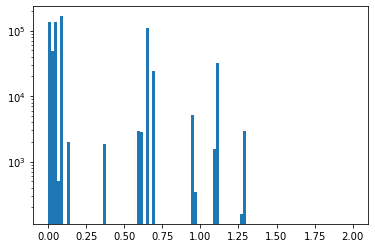

In [36]:
plt.hist(background["XSWeight_norm"], bins=100, range=(0, 2))
plt.yscale("log")

The total number of events will be manually balanced